In [ ]:
# import os, sys, wget
# from zipfile import ZipFile

# url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
# tiny_imgdataset = wget.download('http://cs231n.stanford.edu/tiny-imagenet-200.zip', out = os.getcwd())
# for file in os.listdir(os.getcwd()):
#     if file.endswith(".zip"):
#         zip = ZipFile(file)
#         zip.extractall()
#     else:
#         print("not found")

# About
In this notebook, we will:
1. Import ImageNet data from tensorflow.keras.applications into training & testing subsets.
2.  Train our CNN (Convolutional Neural Network) from digit recognition.
3.  Evaluate our CNN's performance on a subset of test data.
4.  Compare our CNN with the ResNet50 neural net.
5.  Try training on ImageNet dataset above

# Imports

In [1]:
# libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import time

# neural net
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Data
We will load data from the CIFAR10 dataset.

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train
y_train = y_train
x_test = x_test
y_test = y_test

From this dataset, we will pull 10,000 colour training images and 1,000 colour test images, each labelled over 10 categories.

In [7]:
print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test shape: {y_test.shape}')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


Each image is 32×32 pixels. Let's visulise.

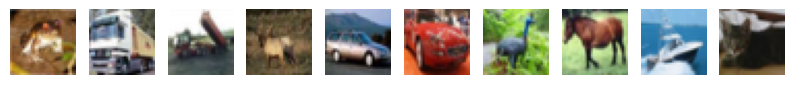

In [8]:
fig, ax = plt.subplots(1,10, figsize = (10,1))

for i in range(10):
    ax[i].imshow(x_train[i])
    ax[i].set_axis_off()

plt.show()

In [9]:
# these are the 10 image categories
labels = ['airplane',
          'automobile',
          'bird',
          'cat',
          'deer',
          'dog',
          'frog',
          'horse',
          'ship',
          'truck']

# 1. Digit Recognition Architecture 
## 1.1 Build model
We will build according to the neural network architecture used in digit recognition, without its trained weights. This architecture proved to perform very well (~92% accuracy) when applied to digit recognition test data.

In [10]:
def get_cnn_model():

    model = Sequential(
        [
            Input(shape = (32,32,3)),
            Conv2D(filters = 32, kernel_size=(3,3), kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0), activation = 'relu'),
            MaxPool2D(pool_size = (2,2)),
            Conv2D(filters = 64, kernel_size=(3,3), kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0), activation = 'relu'),
            MaxPool2D(pool_size = (2,2)),
            Flatten(),
            Dense(64, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=0), activation = 'relu'),
            Dense(10)
        ]
    )

    # define optimizer, loss function & metrics
    model.compile(optimizer = 'adam',
                  loss = SparseCategoricalCrossentropy(from_logits = True),
                  metrics = ['accuracy']
                 )
    
    return model

In [11]:
# early stopping callback
stop_callback = EarlyStopping(patience = 10, monitor = 'val_loss',verbose = 1)

# checkpoint callback to periodically save our model weights
checkpoint_dir = 'DR_architecture_best_weights/1_aftertraining'
checkpoint_callback = ModelCheckpoint(f'{checkpoint_dir}.weights.h5',
                                      save_weights_only = True,
                                      save_best_only = True,
                                      monitor = 'val_loss',
                                      save_freq = 'epoch',
                                        verbose = 0)

In [12]:
model = get_cnn_model()
model.save_weights('DR_architecture_best_weights/0_beforetraining.weights.h5')
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 167,562 (654.54 KB)

 Trainable params: 167,562 (654.54 KB)

 Non-trainable params: 0 (0.00 B)

None


## 1.2 Train Model

In [13]:
train_start_time = time.time()

history = model.fit(x = x_train,
          y = y_train,
          epochs = 200,
          batch_size = 85,
          validation_split = 0.15,
          callbacks = [stop_callback, checkpoint_callback],
          verbose = False)

train_time = time.time()-train_start_time
print(f'Training took {train_time:.1f} seconds')

Epoch 19: early stopping
Training took 166.4 seconds


## 1.3 Results

In [14]:
print(f"Best validation accuracy: {max(history.history['val_accuracy'])*100:.1f}%")

Best validation accuracy: 64.3%


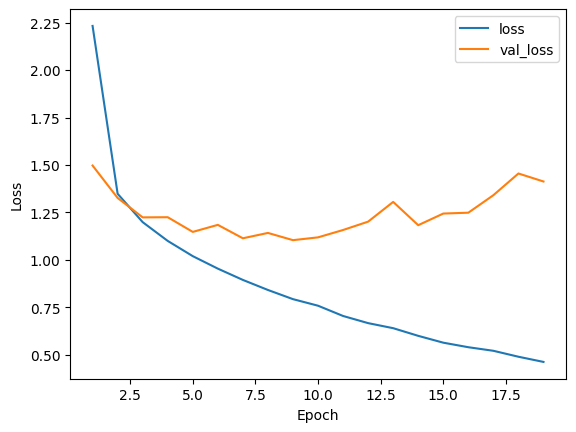

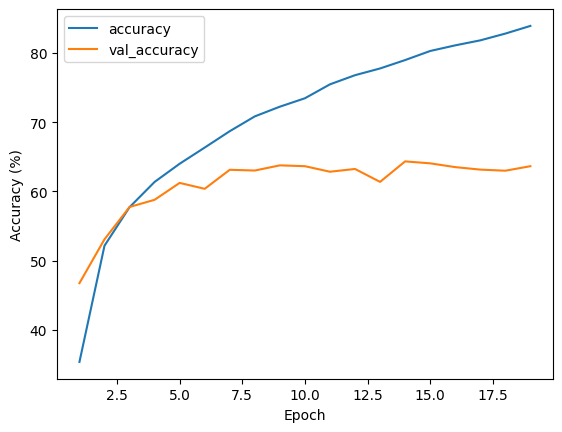

In [15]:
df = pd.DataFrame(history.history)
df.index += 1
plot = df.plot(y = ['loss', 'val_loss'])
plot.set_xlabel('Epoch')
plot.set_ylabel('Loss')
plt.show()
df['val_accuracy_%'] = df['val_accuracy'] * 100
df['accuracy_%'] = df['accuracy'] * 100
plot = df.plot(y = ['accuracy_%', 'val_accuracy_%'])
plot.set_xlabel('Epoch')
plot.set_ylabel('Accuracy (%)')
plot.legend(['accuracy','val_accuracy'])
plt.show()

After only 4 epochs, there is clear signs of overfitting. <br> It can sometimes help to reduce the learning rate when the model improvements stagnate.

## 1.4 Reduce LR Callback

**How does the ReduceLROnPlateau callback work with the Adam Optimizer?** <br>
The Adam optimizer has a base learning rate (by default 0.001). This base learning rate is used to scale all the learning rates for the different weights in the model. <p>
The ReduceLROnPlateau callback then reduces the base learning rate my some factor (by default 0.1), if it sees no improvement on the model's performance after a given number of episodes.<p> 
Now, let's define our callbacks.

In [16]:
# scales lr by lr_factor when the model no longer improves after 'patience' number of epochs
lr_factor = 0.5
lr_callback = ReduceLROnPlateau(monitor = 'val_loss', 
                                patience = 5, 
                                factor = lr_factor,
                                verbose = 1)

# need to reassign EarlyStopping, ModelCheckpoint callbacks so their monitored performance metric "val_loss" is reset.
# If you don't reassign, these callbacks will remember the smallest val_loss value from the previous training run.
# checkpoint_dir must be assigned before checkpoint_callback. Otherwise, the callback will continue to use the previous checkpoint directory.
stop_callback = EarlyStopping(patience = 10, monitor = 'val_loss',verbose = 1)

checkpoint_dir = 'DR_architecture_best_weights/2_lrdecay.weights.h5' 
checkpoint_callback = ModelCheckpoint(f'{checkpoint_dir}.weights.h5',
                                      save_weights_only = True,
                                      save_best_only = True,
                                      monitor = 'val_loss',
                                      save_freq = 'epoch',
                                        verbose = 0)

In [17]:
new_model = get_cnn_model()
new_model.load_weights('DR_architecture_best_weights/0_beforetraining.weights.h5')

In [18]:
train_start_time = time.time()

history = new_model.fit(x_train, y_train,
                    epochs = 200,
                    batch_size = 85,
                    validation_split = 0.15,
                    verbose = False,
                    callbacks = [lr_callback, stop_callback, checkpoint_callback]
                   )

train_time = time.time()-train_start_time
print(f'Training took {train_time:.1f} seconds')


Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 18: early stopping
Training took 153.7 seconds


In [19]:
print(f"Best validation accuracy: {max(history.history['val_accuracy'])*100:.1f}%")

Best validation accuracy: 65.8%


Only a marginal gain.

# 2. ResNet50 Architecture